## Work
請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
from tensorflow.python import keras
import itertools
# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
# Hint 1 : 在 Dense 層中增加 Regularizers
# Hint 2 : 增加 Dropout 層並設定 dropout ratio
# Hint 3 : 增加 Batch-normalization 層
from tensorflow.python.keras.layers import BatchNormalization, Activation, Dropout
from tensorflow.python.keras.regularizers import l1, l2, l1_l2

def build_mlp(input_shape,
              output_units=10,
              num_neurons=[512, 256, 128],
              ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)

    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(
                units=n_units,
                activation="relu",
                name="hidden_layer" + '_l1_' + str(i + 1),
                kernel_regularizer=l1(ratio))(input_layer)
            x = Dropout(0.25)(x)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(
                units=n_units,
                activation="relu",
                name="hidden_layer" + '_l1_l2_' + str(i + 1),
                kernel_regularizer=l1_l2(ratio))(x)
            x = Dropout(0.25)(x)
            x = BatchNormalization()(x)

    out = keras.layers.Dense(
        units=output_units, activation="softmax", name="output")(x)

    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95
EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [7]:
results = {}
for regulizer_ratio in EXP:
    keras.backend.clear_session()
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(
        input_shape=x_train.shape[1:],
        ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(
        lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(
        loss="categorical_crossentropy", metrics=["acc"], optimizer=optimizer)

    model.fit(
        x_train,
        y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(x_test, y_test),
        shuffle=True)

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]

    exp_name_tag = "exp-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {
        'train-loss': train_loss,
        'valid-loss': valid_loss,
        'train-acc': train_acc,
        'valid-acc': valid_acc
    }

Experiment with Regulizer = 0.010000
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer_l1_1 (Dense)    (None, 512)               1573376   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
batch_normalization_v1 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer_l1_l2_2 (Dense) (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_v1_1

Epoch 46/50
50000/50000 [==============================] - 1s 24us/sample - loss: 2.3008 - acc: 0.3098 - val_loss: 2.7730 - val_acc: 0.1718
Epoch 47/50
50000/50000 [==============================] - 1s 24us/sample - loss: 2.3003 - acc: 0.3085 - val_loss: 3.1988 - val_acc: 0.1280
Epoch 48/50
50000/50000 [==============================] - 1s 25us/sample - loss: 2.3111 - acc: 0.3069 - val_loss: 2.6269 - val_acc: 0.2027
Epoch 49/50
50000/50000 [==============================] - 1s 25us/sample - loss: 2.3008 - acc: 0.3102 - val_loss: 2.8327 - val_acc: 0.2008
Epoch 50/50
50000/50000 [==============================] - 1s 25us/sample - loss: 2.3189 - acc: 0.3031 - val_loss: 2.5202 - val_acc: 0.2355
Experiment with Regulizer = 0.000100
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
__________________________________________________

Epoch 41/50
50000/50000 [==============================] - 1s 24us/sample - loss: 5.1723 - acc: 0.5145 - val_loss: 5.1488 - val_acc: 0.5104
Epoch 42/50
50000/50000 [==============================] - 1s 25us/sample - loss: 5.1061 - acc: 0.5154 - val_loss: 5.0797 - val_acc: 0.5153
Epoch 43/50
50000/50000 [==============================] - 1s 26us/sample - loss: 5.0343 - acc: 0.5227 - val_loss: 5.0137 - val_acc: 0.5180
Epoch 44/50
50000/50000 [==============================] - 1s 25us/sample - loss: 4.9729 - acc: 0.5243 - val_loss: 4.9597 - val_acc: 0.5130
Epoch 45/50
50000/50000 [==============================] - 1s 24us/sample - loss: 4.9044 - acc: 0.5253 - val_loss: 4.8965 - val_acc: 0.5187
Epoch 46/50
50000/50000 [==============================] - 1s 25us/sample - loss: 4.8461 - acc: 0.5319 - val_loss: 4.8595 - val_acc: 0.5060
Epoch 47/50
50000/50000 [==============================] - 1s 25us/sample - loss: 4.7844 - acc: 0.5348 - val_loss: 4.7881 - val_acc: 0.5197
Epoch 48/50
50000/50

50000/50000 [==============================] - 1s 25us/sample - loss: 2.7048 - acc: 0.4921 - val_loss: 2.6485 - val_acc: 0.4993
Epoch 37/50
50000/50000 [==============================] - 1s 24us/sample - loss: 2.6522 - acc: 0.4916 - val_loss: 2.5983 - val_acc: 0.5002
Epoch 38/50
50000/50000 [==============================] - 1s 25us/sample - loss: 2.5911 - acc: 0.4958 - val_loss: 2.5516 - val_acc: 0.5046
Epoch 39/50
50000/50000 [==============================] - 1s 25us/sample - loss: 2.5342 - acc: 0.5008 - val_loss: 2.4986 - val_acc: 0.5041
Epoch 40/50
50000/50000 [==============================] - 1s 25us/sample - loss: 2.4863 - acc: 0.5012 - val_loss: 2.4601 - val_acc: 0.4986
Epoch 41/50
50000/50000 [==============================] - 1s 25us/sample - loss: 2.4373 - acc: 0.5017 - val_loss: 2.4061 - val_acc: 0.5116
Epoch 42/50
50000/50000 [==============================] - 1s 25us/sample - loss: 2.3872 - acc: 0.5076 - val_loss: 2.3681 - val_acc: 0.5057
Epoch 43/50
50000/50000 [=======

50000/50000 [==============================] - 1s 25us/sample - loss: 3.0222 - acc: 0.4743 - val_loss: 2.9601 - val_acc: 0.4901
Epoch 32/50
50000/50000 [==============================] - 1s 25us/sample - loss: 2.9504 - acc: 0.4804 - val_loss: 2.8859 - val_acc: 0.4949
Epoch 33/50
50000/50000 [==============================] - 1s 25us/sample - loss: 2.8827 - acc: 0.4816 - val_loss: 2.8021 - val_acc: 0.5037
Epoch 34/50
50000/50000 [==============================] - 1s 25us/sample - loss: 2.8175 - acc: 0.4877 - val_loss: 2.7534 - val_acc: 0.5049
Epoch 35/50
50000/50000 [==============================] - 1s 24us/sample - loss: 2.7562 - acc: 0.4907 - val_loss: 2.7017 - val_acc: 0.5005
Epoch 36/50
50000/50000 [==============================] - 1s 23us/sample - loss: 2.7000 - acc: 0.4932 - val_loss: 2.6618 - val_acc: 0.4992
Epoch 37/50
50000/50000 [==============================] - 1s 24us/sample - loss: 2.6454 - acc: 0.4911 - val_loss: 2.5855 - val_acc: 0.5089
Epoch 38/50
50000/50000 [=======

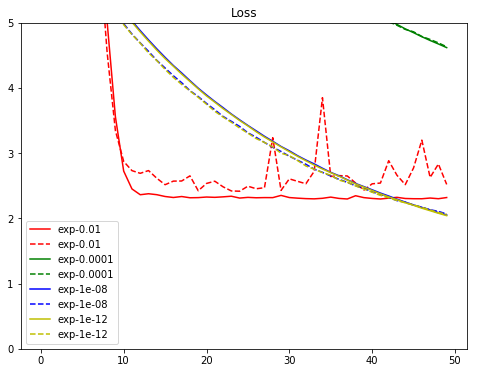

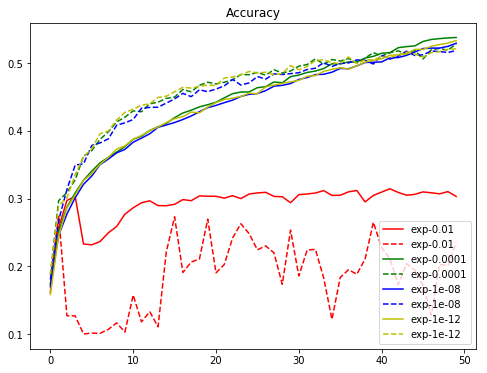

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8, 6))
for i, cond in enumerate(results.keys()):
    plt.plot(
        range(len(results[cond]['train-loss'])),
        results[cond]['train-loss'],
        '-',
        label=cond,
        color=color_bar[i])
    plt.plot(
        range(len(results[cond]['valid-loss'])),
        results[cond]['valid-loss'],
        '--',
        label=cond,
        color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
for i, cond in enumerate(results.keys()):
    plt.plot(
        range(len(results[cond]['train-acc'])),
        results[cond]['train-acc'],
        '-',
        label=cond,
        color=color_bar[i])
    plt.plot(
        range(len(results[cond]['valid-acc'])),
        results[cond]['valid-acc'],
        '--',
        label=cond,
        color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()